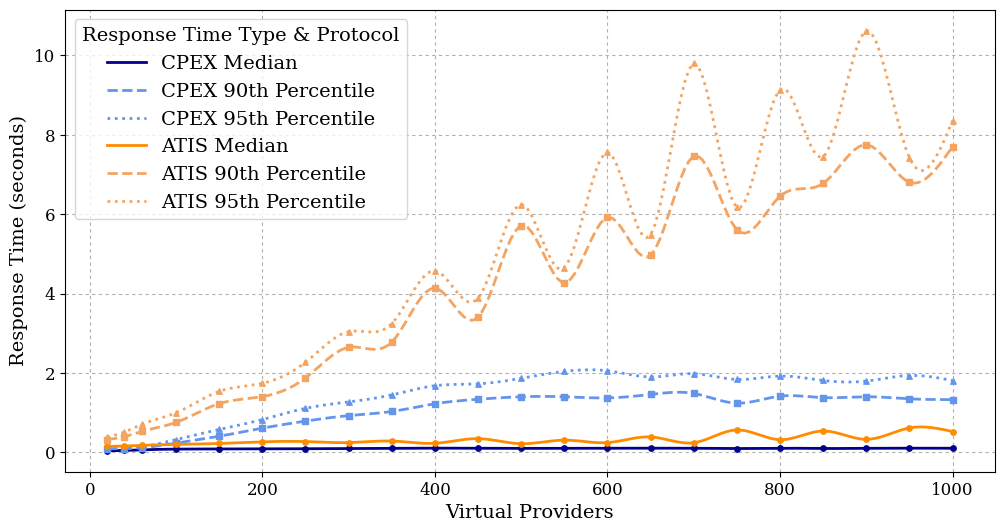

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.interpolate as interp
import matplotlib as mpl

# Set global font settings to a serif font like Times New Roman
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12

# Load the CSV file
df = pd.read_csv('../k6-rt.csv')

# Convert response times from milliseconds to seconds
df["Median"] = df["Median"] / 1000
df["P(90)"] = df["P(90)"] / 1000
df["P(95)"] = df["P(95)"] / 1000
df["Protocol"] = df["Protocol"].str.lower()

# Function to generate smooth interpolated lines
def smooth_line(x, y):
    if len(x) < 4:  # Not enough points for a good cubic spline
        return x, y
    cubic_spline = interp.CubicSpline(x, y, bc_type='natural')
    x_smooth = np.linspace(min(x), max(x), 200)  # Generate smooth x values
    y_smooth = cubic_spline(x_smooth)  # Interpolate y values
    return x_smooth, y_smooth

# ------------------------------ Response Time Chart ------------------------------
plt.figure(figsize=(12, 6))

# Define colors for better contrast
color_medians = {"cpex": "darkblue", "atis": "darkorange"}  
color_percentiles = {"cpex": "cornflowerblue", "atis": "sandybrown"}  

# Process each protocol separately
for protocol in ["cpex", "atis"]:
    subset = df[df["Protocol"] == protocol].sort_values("VUs")

    # Smooth lines using cubic spline interpolation
    x_median, y_median = smooth_line(subset["VUs"], subset["Median"])
    x_p90, y_p90 = smooth_line(subset["VUs"], subset["P(90)"])
    x_p95, y_p95 = smooth_line(subset["VUs"], subset["P(95)"])

    # Plot smoothed lines (zorder=2 keeps them above the grid)
    plt.plot(x_median, y_median, color=color_medians[protocol], linestyle="solid", linewidth=2, label=f"{protocol.upper()} Median", zorder=2)
    plt.plot(x_p90, y_p90, color=color_percentiles[protocol], linestyle="dashed", linewidth=2, label=f"{protocol.upper()} 90th Percentile", zorder=2)
    plt.plot(x_p95, y_p95, color=color_percentiles[protocol], linestyle="dotted", linewidth=2, label=f"{protocol.upper()} 95th Percentile", zorder=2)

    # Overlay original data points (SMALLER SIZE, NO BORDERS, zorder=3 to be on top)
    plt.scatter(subset["VUs"], subset["Median"], color=color_medians[protocol], marker="o", s=15, zorder=3)
    plt.scatter(subset["VUs"], subset["P(90)"], color=color_percentiles[protocol], marker="s", s=15, zorder=3)
    plt.scatter(subset["VUs"], subset["P(95)"], color=color_percentiles[protocol], marker="^", s=15, zorder=3)

# Labels, title, and grid
# plt.title("Response Time Comparison (Median, 90th, and 95th Percentile)", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Virtual Providers", fontsize=14)
plt.ylabel("Response Time (seconds)", fontsize=14)
plt.legend(title="Response Time Type & Protocol", fontsize=14, title_fontsize=14)

# Move grid to background (zorder=0)
plt.grid(True, linestyle=(0, (3, 3)), linewidth=0.8, zorder=0)

# Save to PDF (Preserve UI exactly, no extra borders)
plt.savefig("../charts/res-time.pdf", bbox_inches='tight', dpi=300)
plt.show()
